# Basic Tutorial

Trey V. Wenger (c) June 2024

Here we demonstrate the various ways to use `mcmc_yplus`. We start by importing the package and generating some the example data.

In [1]:
from IPython.display import SVG, display
    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np

import mcmc_yplus
from mcmc_yplus.model import Model
from mcmc_yplus.plots import plot_pair

print("mcmc_yplus:", mcmc_yplus.__version__)

pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "svg"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

mcmc_yplus: 0.0.1b


In [2]:
# Generate synthetic data
poly_coeffs = [1.0e-7, -2.0e-6, 0.0, 0.1]
H_centers = [-15.0, 20.0]
H_fwhms = [30.0, 35.0]
H_peaks = [10.0, 20.0]
He_H_fwhm_ratio = 0.9
yplus = 0.08
He_offset = 122.15

channel = np.linspace(-300.0, 200.0, 1000)
rms = 1.0
spectrum = rng.normal(loc=0.0, scale=rms, size=1000)
spectrum += np.polyval(poly_coeffs, channel)
for H_center, H_fwhm, H_peak in zip(H_centers, H_fwhms, H_peaks):
    # H component
    spectrum += H_peak * np.exp(-4.0 * np.log(2.0) * (channel - H_center)**2.0 / H_fwhm**2.0)
    
    # He component
    He_fwhm = H_fwhm * He_H_fwhm_ratio
    He_peak = H_peak * yplus / He_H_fwhm_ratio
    He_center = H_center - He_offset
    spectrum += He_peak * np.exp(-4.0 * np.log(2.0) * (channel - He_center)**2.0 / He_fwhm**2.0)
    
data = {
    "velocity": channel,
    "spectrum": spectrum,
    "noise": np.ones_like(spectrum) * rms,
}
print(data.keys())

dict_keys(['velocity', 'spectrum', 'noise'])


Here we create a data dictionary in the format expected by `mcmc_yplus`. Each dictionary element is a 1-D array of scalar values, where all of the arrays must have the same length. The `velocity` axis has units `km s-1` and the `spectrum` is the brightness temperature in `K`. The `noise` arrays define the channel-dependent rms spectral noise (in brightness temperature, `K`).

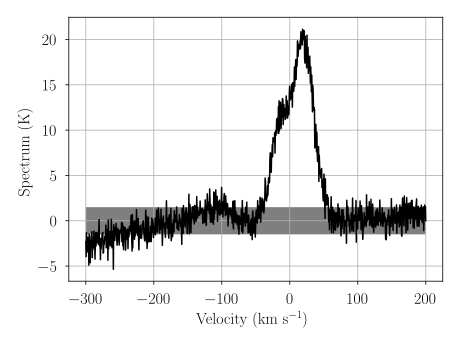

In [3]:
# Plot example data
fig, ax0 = plt.subplots()
ax0.plot(data["velocity"], data["spectrum"], "k-")
ax0.fill_between(
    data["velocity"],
    -1.5 * data["noise"],
    1.5 * data["noise"],
    color="k",
    edgecolor="none",
    lw=0,
    alpha=0.5,
)
ax0.set_ylabel("Spectrum (K)")
ax0.set_xlabel(r"Velocity (km s$^{-1}$)")
fig.tight_layout()
fig.savefig(f"{figdir}/data.{ext}")
plt.close(fig)

SVG(f"{figdir}/data.{ext}")

## `Model`

We begin with a two-cloud (`n_cloud=2`) model, with a 3rd order polynomial baseline (`baseline_degree=3`).

In [4]:
model = Model(data, n_clouds=2, baseline_degree=3, seed=1234, verbose=True)

# use default priors
# model.set_priors()

# manually set priors
model.set_priors(
    prior_H_amplitude = 10.0, # K
    prior_H_center = [0.0, 25.0], # km s-1
    prior_H_fwhm = 20.0, # km s-1
    prior_yplus = 0.1,
    prior_He_H_fwhm_ratio = 0.1,
)

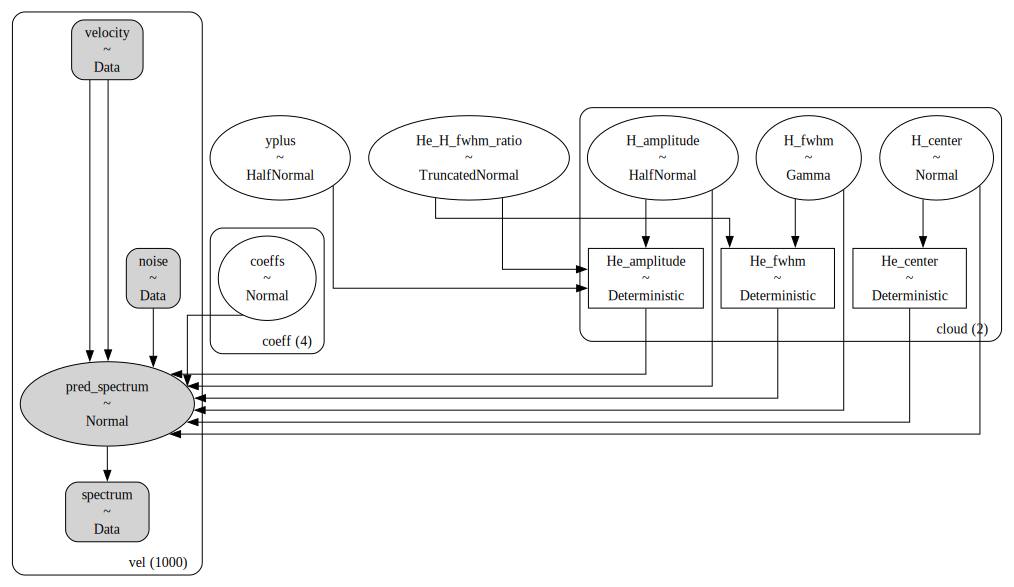

In [5]:
# Plot model graph
model.plot_graph(f"{figdir}/model.gv", "svg")
SVG(f"{figdir}/model.gv.{ext}")

In [6]:
# model string representation
print(model.model.str_repr())

            coeffs ~ Normal(0, 1)
       H_amplitude ~ HalfNormal(0, 10)
          H_center ~ Normal(0, 25)
            H_fwhm ~ Gamma(2, f())
             yplus ~ HalfNormal(0, 0.1)
   He_H_fwhm_ratio ~ TruncatedNormal(1, 0.1, 0, inf)
      He_amplitude ~ Deterministic(f(He_H_fwhm_ratio, H_amplitude, yplus))
         He_center ~ Deterministic(f(H_center))
           He_fwhm ~ Deterministic(f(H_fwhm, He_H_fwhm_ratio))
pred_spectrum_norm ~ Normal(f(H_amplitude, coeffs, He_H_fwhm_ratio, H_fwhm, yplus, H_center), 1)


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

In [7]:
# prior predictive check
prior = model.prior_predictive_check(
    samples=100,  # prior predictive samples
    plot_fname=f"{figdir}/prior_predictive.{ext}",
)
SVG(f"{figdir}/prior_predictive.{ext}")

Sampling: [H_amplitude, H_center, H_fwhm, He_H_fwhm_ratio, coeffs, pred_spectrum_norm, yplus]


We can also generate a pair plot to inspect the prior distributions and their effect on deterministic quantities. The model has attributes `cloud_params` for cloud free parameters, `deterministics` for deterministic quantities, `baseline_params` for the free polynomial baseline parameters, and `hyper_params` for the hyperparameters. Here we show the pair plot for the deterministic quantities derived from our prior distributions.

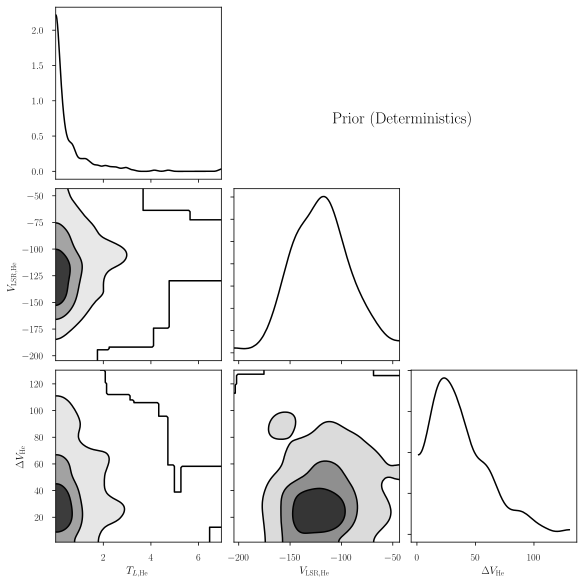

In [8]:
plot_pair(
    prior.prior, # samples
    model.deterministics, # var_names to plot
    "Prior (Deterministics)", # plot label
    f"{figdir}/pair_prior_determ.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_prior_determ.{ext}")

## Variational Inference

We can approximate the posterior distribution using variational inference (VI). We will run a maximum of `n` iterations, but stop early if it appears that VI has converged on a solution. If you get a `NaN` error, try increasing `learning_rate` and `abs_tolerance`.

In [9]:
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.03, # VI relative convergence threshold
    abs_tolerance = 0.03, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)

Output()

Convergence achieved at 46900
Interrupted at 46,899 [46%]: Average Loss = 1,646.8


In [10]:
# posterior samples stored in model.trace.posterior
az.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
H_amplitude[0]     9.843  0.162    9.532   10.136      0.005    0.004   
H_amplitude[1]    19.857  0.145   19.608   20.148      0.005    0.003   
H_center[0]      -15.813  0.299  -16.479  -15.325      0.010    0.007   
H_center[1]       19.783  0.171   19.484   20.121      0.006    0.004   
H_fwhm[0]         28.490  0.520   27.616   29.531      0.016    0.011   
H_fwhm[1]         36.829  0.301   36.299   37.405      0.009    0.007   
He_H_fwhm_ratio    0.981  0.070    0.853    1.108      0.003    0.002   
He_amplitude[0]    0.839  0.088    0.674    0.998      0.003    0.002   
He_amplitude[1]    1.692  0.177    1.383    2.023      0.006    0.004   
He_center[0]    -137.963  0.299 -138.629 -137.475      0.010    0.007   
He_center[1]    -102.367  0.171 -102.666 -102.029      0.006    0.004   
He_fwhm[0]        27.959  2.085   23.646   31.424      0.075    0.053   
He_fwhm[1]        36.141  2.617   31.229   40.794      0.098    0.069   
coeffs[0]          0.014  0.036   -0.050    0.086      0.001    0.001   
coeffs[1]          0.028  0.036   -0.035    0.101      0.001    0.001   
coeffs[2]         -0.311  0.024   -0.354   -0.263      0.001    0.001   
coeffs[3]          0.339  0.018    0.305    0.371      0.001    0.000   
yplus              0.083  0.006    0.073    0.097      0.000    0.000   

                 ess_bulk  ess_tail  r_hat  
H_amplitude[0]     1051.0    1067.0    NaN  
H_amplitude[1]      969.0     949.0    NaN  
H_center[0]         884.0     882.0    NaN  
H_center[1]         918.0     588.0    NaN  
H_fwhm[0]          1034.0     908.0    NaN  
H_fwhm[1]          1063.0    1054.0    NaN  
He_H_fwhm_ratio     707.0     709.0    NaN  
He_amplitude[0]     902.0     941.0    NaN  
He_amplitude[1]     920.0     846.0    NaN  
He_center[0]        884.0     882.0    NaN  
He_center[1]        918.0     588.0    NaN  
He_fwhm[0]          785.0     898.0    NaN  
He_fwhm[1]          716.0     783.0    NaN  
coeffs[0]          1049.0     973.0    NaN  
coeffs[1]           945.0     915.0    NaN  
coeffs[2]           882.0     978.0    NaN  
coeffs[3]          1028.0     906.0    NaN  
yplus               971.0     875.0    NaN

## MCMC

VI is fast, but it's not particularly accurate, and there is no way to diagnose "convergence". Instead, we sample the posterior distribution using MCMC. Here we initialize the No U-Turn Sampler (NUTS) using VI. We can customize the VI initialization as well as the NUTS parameters. If there are many divergences, or if the resulting effective sample sizes are small and `r_hat` is large, try increasing the number of tuning samples, draws, and/or chains. Increasing `target_accept` to `0.9` or `0.95` can help if there are many divergences. Use as many chains as possible.

In [11]:
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.03, "abs_tolerance": 0.03, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 46900
Interrupted at 46,899 [9%]: Average Loss = 1,646.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeffs, H_amplitude, H_center, H_fwhm, yplus, He_H_fwhm_ratio]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


If a chain does not converge, an error is printed and that chain is dropped from all subsequent analyses. In the remaining chains, there may be some divergences. The number of divergences should be much less than the number of posterior samples.

In general, there could be a labeling degeneracy, or multiple unique solutions. Here we "solve" for those effects using a Gaussian Mixture Model (GMM). The parameter `p_threshold` defines the probability threshold for "unique" GMM solutions.

In [12]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [13]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
H_amplitude[0]     9.920  0.291    9.369   10.488      0.006    0.004   
H_amplitude[1]    19.875  0.199   19.511   20.257      0.004    0.003   
H_center[0]      -15.721  0.659  -17.012  -14.521      0.016    0.011   
H_center[1]       19.825  0.396   19.108   20.588      0.010    0.007   
H_fwhm[0]         29.019  1.205   26.666   31.235      0.027    0.019   
H_fwhm[1]         36.704  0.800   35.156   38.134      0.019    0.014   
He_H_fwhm_ratio    0.973  0.077    0.834    1.117      0.001    0.001   
He_amplitude[0]    0.856  0.090    0.682    1.019      0.002    0.001   
He_amplitude[1]    1.715  0.169    1.407    2.037      0.003    0.002   
He_center[0]    -137.871  0.659 -139.162 -136.671      0.016    0.011   
He_center[1]    -102.325  0.396 -103.042 -101.562      0.010    0.007   
He_fwhm[0]        28.236  2.515   23.810   33.105      0.044    0.031   
He_fwhm[1]        35.714  2.935   30.217   41.151      0.052    0.037   
coeffs[0]          0.006  0.085   -0.143    0.176      0.002    0.001   
coeffs[1]          0.039  0.096   -0.146    0.211      0.002    0.002   
coeffs[2]         -0.312  0.050   -0.405   -0.218      0.001    0.001   
coeffs[3]          0.336  0.048    0.249    0.427      0.001    0.001   
yplus              0.084  0.008    0.068    0.100      0.000    0.000   

                 ess_bulk  ess_tail  r_hat  
H_amplitude[0]     2313.0    2661.0    1.0  
H_amplitude[1]     3138.0    2842.0    1.0  
H_center[0]        1741.0    1903.0    1.0  
H_center[1]        1713.0    2083.0    1.0  
H_fwhm[0]          2026.0    1939.0    1.0  
H_fwhm[1]          1749.0    2242.0    1.0  
He_H_fwhm_ratio    3620.0    2723.0    1.0  
He_amplitude[0]    3409.0    3102.0    1.0  
He_amplitude[1]    4008.0    2711.0    1.0  
He_center[0]       1741.0    1903.0    1.0  
He_center[1]       1713.0    2083.0    1.0  
He_fwhm[0]         3235.0    2844.0    1.0  
He_fwhm[1]         3165.0    2749.0    1.0  
coeffs[0]          2275.0    2298.0    1.0  
coeffs[1]          2830.0    2541.0    1.0  
coeffs[2]          2200.0    2403.0    1.0  
coeffs[3]          2788.0    2917.0    1.0  
yplus              2704.0    3099.0    1.0

It's good practice to verify the integrity of your solution! Here we generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color, and the "thin" lines are the contributions of individual clouds. Each line is one posterior sample.

Sampling: [pred_spectrum_norm]


Output()

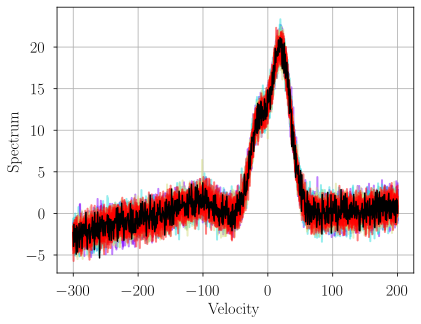

In [14]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive.{ext}"
)
SVG(f"{figdir}/posterior_predictive.{ext}")

In [15]:
model.plot_traces(f"{figdir}/traces.{ext}")
SVG(f"{figdir}/traces.{ext}")

We can inspect the posterior distribution pair plots. First, the cloud parameters.

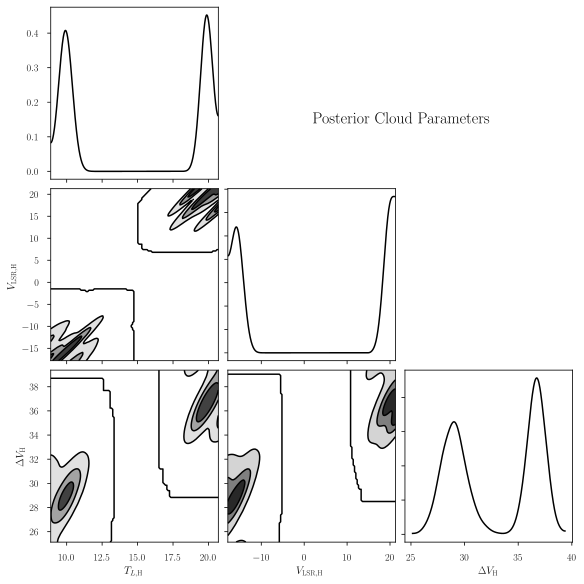

In [16]:
plot_pair(
    model.trace.solution_0, # samples
    model.cloud_params, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params.{ext}")

Notice that there are two posterior modes. These correspond to the two clouds of the model. We can plot the posterior distributions for a single cloud.

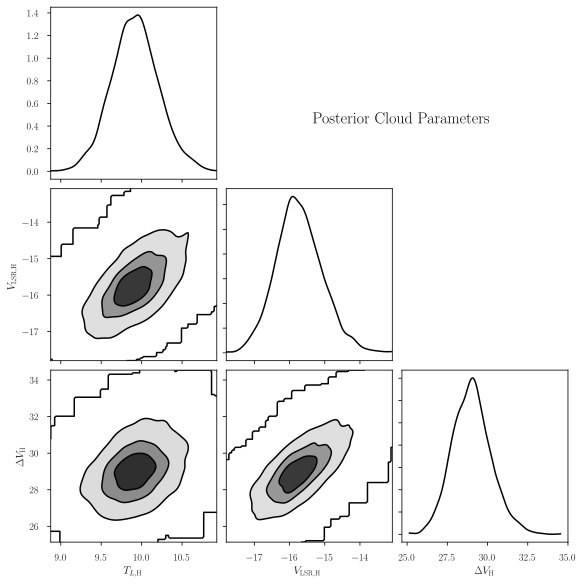

In [17]:
plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_params, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params_0.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params_0.{ext}")

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [18]:
point_stats = az.summary(model.trace.solution_0, var_names=model.cloud_params + model.hyper_params, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: 2888.122014413493


mean     sd  hdi_16%  hdi_84%
H_amplitude[0]    9.920  0.291    9.641   10.209
H_amplitude[1]   19.875  0.199   19.669   20.053
H_center[0]     -15.721  0.659  -16.420  -15.159
H_center[1]      19.825  0.396   19.367   20.134
H_fwhm[0]        29.019  1.205   27.781   30.103
H_fwhm[1]        36.704  0.800   35.927   37.499
yplus             0.084  0.008    0.076    0.092
He_H_fwhm_ratio   0.973  0.077    0.890    1.042